In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = f'/gxfs_work/geomar/smomw523/master-thesis/output_data/retention/mussnichtinTiefenschichtbleiben/'

In [3]:
import warnings
warnings.filterwarnings('ignore')

all_files = glob.glob(os.path.join(path, "2*.csv"))
dates = pd.date_range(start='2009-01-01', end='2009-12-31', freq = '5D')
df = pd.concat((pd.read_csv(f, index_col=0,skipfooter=1) for f in all_files), keys=dates)
df.index.names = ['start_date', 'obs']

In [4]:
dx = df.to_xarray()

In [5]:
dx

<xarray.Dataset>
Dimensions:               (start_date: 73, obs: 43)
Coordinates:
  * start_date            (start_date) datetime64[ns] 2009-01-01 ... 2009-12-27
  * obs                   (obs) int64 0 1 2 3 4 5 6 7 ... 36 37 38 39 40 41 42
Data variables:
    INALT-ML              (start_date, obs) float64 0.9196 0.7962 ... 0.0 0.0
    INALT-rest            (start_date, obs) float64 0.905 0.7523 ... 0.02062
    INALT-bottom-100      (start_date, obs) float64 1.0 0.8935 ... 0.1638 0.1599
    ROMS-ML               (start_date, obs) float64 0.8085 0.4071 ... 0.0 0.0
    ROMS-rest             (start_date, obs) float64 0.7913 0.4532 ... 5.837e-05
    ROMS-bottom-100       (start_date, obs) float64 0.982 0.7449 ... 0.000123
    ROMSchild-ML          (start_date, obs) float64 0.8458 0.4036 ... 0.0003375
    ROMSchild-rest        (start_date, obs) float64 0.8592 0.5171 ... 0.001601
    ROMSchild-bottom-100  (start_date, obs) float64 0.9972 0.5304 ... 0.0005066

In [44]:
interp_dx = dx.mean(dim='start_date').interp(obs=np.linspace(0, 42, 40000))
threshold_value = 1/np.e
indices = (interp_dx < threshold_value).argmax(dim='obs')

In [45]:
indices

<xarray.Dataset>
Dimensions:               ()
Data variables:
    INALT-ML              int64 1542
    INALT-rest            int64 6393
    INALT-bottom-100      int64 36592
    ROMS-ML               int64 1041
    ROMS-rest             int64 2187
    ROMS-bottom-100       int64 2619
    ROMSchild-ML          int64 1094
    ROMSchild-rest        int64 2244
    ROMSchild-bottom-100  int64 1717

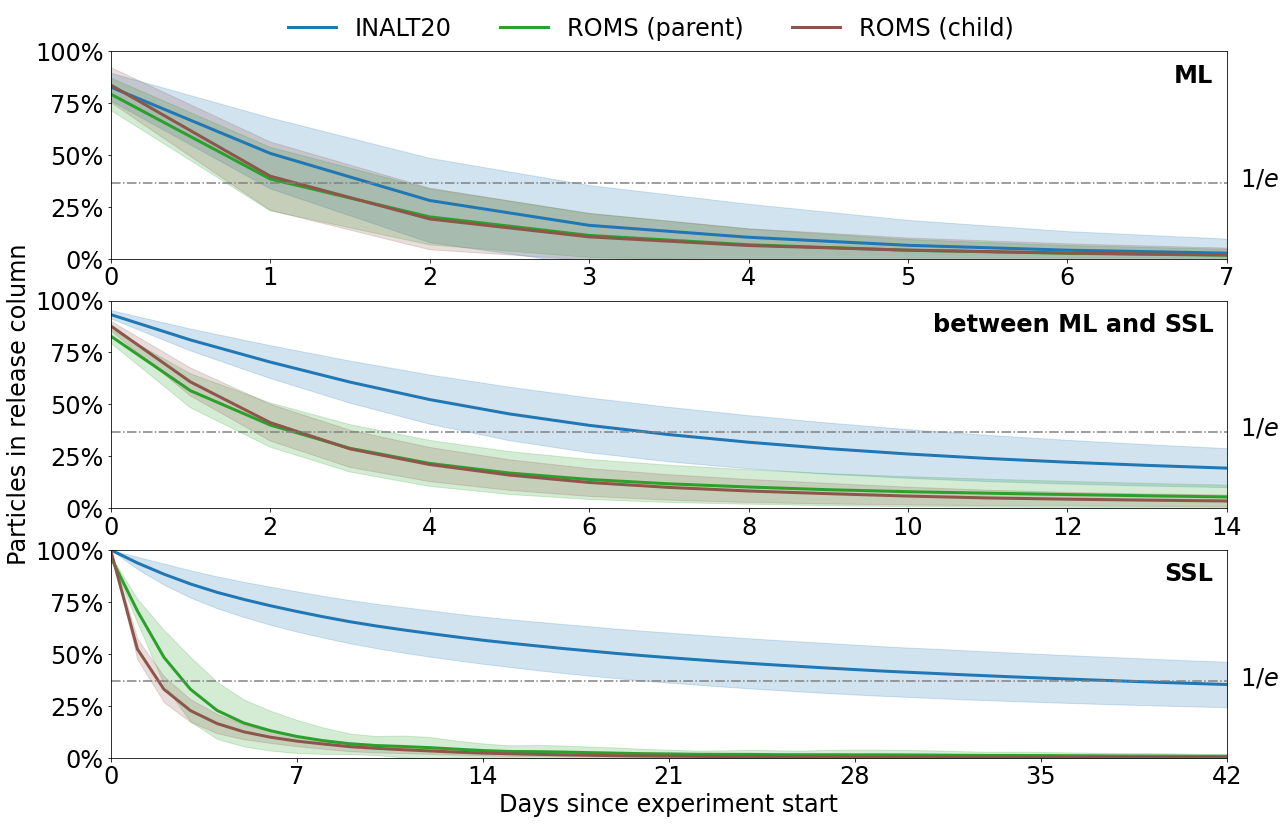

In [11]:
plt.rcParams.update({'font.size': 24,#'axes.labelsize': 22,
                    })

fig, axs = plt.subplots(3, 1, figsize=(20, 13))

lines = []
labels = []

xlabels = ['','','Days since experiment start']
ylabels = ['','Particles in release column','']
xticks = [[0, 1,2,3,4,5,6,7],[0, 2, 4, 6, 8, 10, 12, 14],[0, 7, 14, 21, 28, 35, 42]]

INALT = ['INALT-ML','INALT-rest','INALT-bottom-100']
ROMS = ['ROMS-ML','ROMS-rest','ROMS-bottom-100']
ROMSchild = ['ROMSchild-ML','ROMSchild-rest','ROMSchild-bottom-100']

for i, ax in enumerate(axs, start=1):
    mean_values = dx[INALT[i-1]].mean(dim='start_date')
    upper_envelope = mean_values + dx[INALT[i-1]].std(dim='start_date')
    lower_envelope = mean_values - dx[INALT[i-1]].std(dim='start_date')

    mean_values_ROMS = dx[ROMS[i-1]].mean(dim='start_date')
    upper_envelope_ROMS = mean_values_ROMS + dx[ROMS[i-1]].std(dim='start_date')
    lower_envelope_ROMS = mean_values_ROMS - dx[ROMS[i-1]].std(dim='start_date')

    mean_values_ROMSchild = dx[ROMSchild[i-1]].mean(dim='start_date')
    upper_envelope_ROMSchild = mean_values_ROMSchild + dx[ROMSchild[i-1]].std(dim='start_date')
    lower_envelope_ROMSchild = mean_values_ROMSchild - dx[ROMSchild[i-1]].std(dim='start_date')

    line1, = ax.plot(np.arange(len(dx.obs)), mean_values, color='tab:blue', linewidth=3, label='INALT20')
    ax.fill_between(np.arange(len(dx.obs)), lower_envelope, upper_envelope, color='tab:blue', alpha=0.2)

    line2, = ax.plot(np.arange(len(dx.obs)), mean_values_ROMS, color='tab:green', linewidth=3, label='ROMS (parent)')
    ax.fill_between(np.arange(len(dx.obs)), lower_envelope_ROMS, upper_envelope_ROMS, color='tab:green', alpha=0.2)

    line3, = ax.plot(np.arange(len(dx.obs)), mean_values_ROMSchild, color='tab:brown', linewidth=3, label='ROMS (child)')
    ax.fill_between(np.arange(len(dx.obs)), lower_envelope_ROMSchild, upper_envelope_ROMSchild, color='tab:brown', alpha=0.2)
    
    ax.text([7+.5/6,14+.5/3,42.5][i-1],0.35,'$1/e$')
    ax.text([7-.5/6,14-.5/3,41.5][i-1],0.85,['ML','between ML and SSL','SSL'][i-1],horizontalalignment='right', fontweight='bold')
    
    ax.axhline(y=1 / np.e, color='gray', linestyle='-.')
    ax.set_xticks(xticks[i-1])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1], ['0%', '25%', '50%', '75%', '100%'])
    ax.set_xlim([0, 7 if i == 1 else 14 if i == 2 else 42])
    ax.set_ylim([0, 1])
    ax.set_xlabel(xlabels[i-1])
    ax.set_ylabel(ylabels[i-1])

    if 'INALT20' not in labels:
        lines.append(line1)
        labels.append('INALT20')
    if 'ROMS (parent)' not in labels:
        lines.append(line2)
        labels.append('ROMS (parent)')
    if 'ROMS (child)' not in labels:
        lines.append(line3)
        labels.append('ROMS (child)')

fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=3, frameon=False)

plt.savefig('../../output_data/rp-mean.pdf', bbox_inches='tight')
plt.show()


In [6]:
# First time passing threshold
ML_INALT, ML_ROMS, ML_ROMSchild = [], [], []
MLtip_INALT, MLtip_ROMS, MLtip_ROMSchild = [], [], []
tip1500_INALT, tip1500_ROMS, tip1500_ROMSchild = [], [], []
threshold = 1/np.e

for j in np.arange(len(dx.start_date)):
    dx.isel(start_date=j)['INALT-ML'].plot()
    dx.isel(start_date=j)['ROMS-ML'].plot()
    dx.isel(start_date=j)['ROMSchild-ML'].plot()
    dx.isel(start_date=j)['INALT-rest'].plot()
    dx.isel(start_date=j)['ROMS-rest'].plot()
    dx.isel(start_date=j)['ROMSchild-rest'].plot()
    dx.isel(start_date=j)['INALT-bottom-100'].plot()
    dx.isel(start_date=j)['ROMS-bottom-100'].plot()
    dx.isel(start_date=j)['ROMSchild-bottom-100'].plot()

    lines = plt.gca().get_lines()
    x_data = lines[0].get_xdata()
    y_data1 = lines[0].get_ydata()
    y_data2 = lines[1].get_ydata()
    y_data3 = lines[2].get_ydata()
    y_data4 = lines[3].get_ydata()
    y_data5 = lines[4].get_ydata()
    y_data6 = lines[5].get_ydata()
    y_data7 = lines[6].get_ydata()
    y_data8 = lines[7].get_ydata()
    y_data9 = lines[8].get_ydata()

    intersec_INALT, intersec_INALT2, intersec_INALT3 = None, None, None
    intersec_ROMS, intersec_ROMS2, intersec_ROMS3 = None, None, None
    intersec_ROMSchild, intersec_ROMSchild2, intersec_ROMSchild3 = None, None, None

    for i in range(len(x_data)):
        if y_data1[i] < threshold and intersec_INALT is None:
            intersec_INALT = x_data[i]
        if y_data2[i] < threshold and intersec_ROMS is None:
            intersec_ROMS = x_data[i]
        if y_data3[i] < threshold and intersec_ROMSchild is None:
            intersec_ROMSchild = x_data[i]
        if y_data4[i] < threshold and intersec_INALT2 is None:
            intersec_INALT2 = x_data[i]
        if y_data5[i] < threshold and intersec_ROMS2 is None:
            intersec_ROMS2 = x_data[i]
        if y_data6[i] < threshold and intersec_ROMSchild2 is None:
            intersec_ROMSchild2 = x_data[i]
        if y_data7[i] < threshold and intersec_INALT3 is None:
            intersec_INALT3 = x_data[i]
        if y_data8[i] < threshold and intersec_ROMS3 is None:
            intersec_ROMS3 = x_data[i]
        if y_data9[i] < threshold and intersec_ROMSchild3 is None:
            intersec_ROMSchild3 = x_data[i]
    
    ML_INALT.append(intersec_INALT)
    ML_ROMS.append(intersec_ROMS)
    ML_ROMSchild.append(intersec_ROMSchild)
    MLtip_INALT.append(intersec_INALT2)
    MLtip_ROMS.append(intersec_ROMS2)
    MLtip_ROMSchild.append(intersec_ROMSchild2)
    tip1500_INALT.append(intersec_INALT3)
    tip1500_ROMS.append(intersec_ROMS3)
    tip1500_ROMSchild.append(intersec_ROMSchild3)
    plt.close()

In [7]:
dict = {'INALT-ML': ML_INALT,'INALT-ML-to-tip': MLtip_INALT,'INALT-tip-to-1500': tip1500_INALT,
        'ROMS-ML': ML_ROMS,'ROMS-ML-to-tip': MLtip_ROMS,'ROMS-tip-to-1500': tip1500_ROMS,
        'ROMSchild-ML': ML_ROMSchild,'ROMSchild-ML-to-tip': MLtip_ROMSchild,'ROMSchild-tip-to-1500': tip1500_ROMSchild}

In [8]:
retentions = pd.DataFrame(dict,index=dates).fillna(43.5)

In [10]:
retentions.mean()

INALT-ML                  2.452055
INALT-ML-to-tip           7.904110
INALT-tip-to-1500        33.589041
ROMS-ML                   1.767123
ROMS-ML-to-tip            2.986301
ROMS-tip-to-1500          3.465753
ROMSchild-ML              1.794521
ROMSchild-ML-to-tip       2.945205
ROMSchild-tip-to-1500     2.246575
dtype: float64

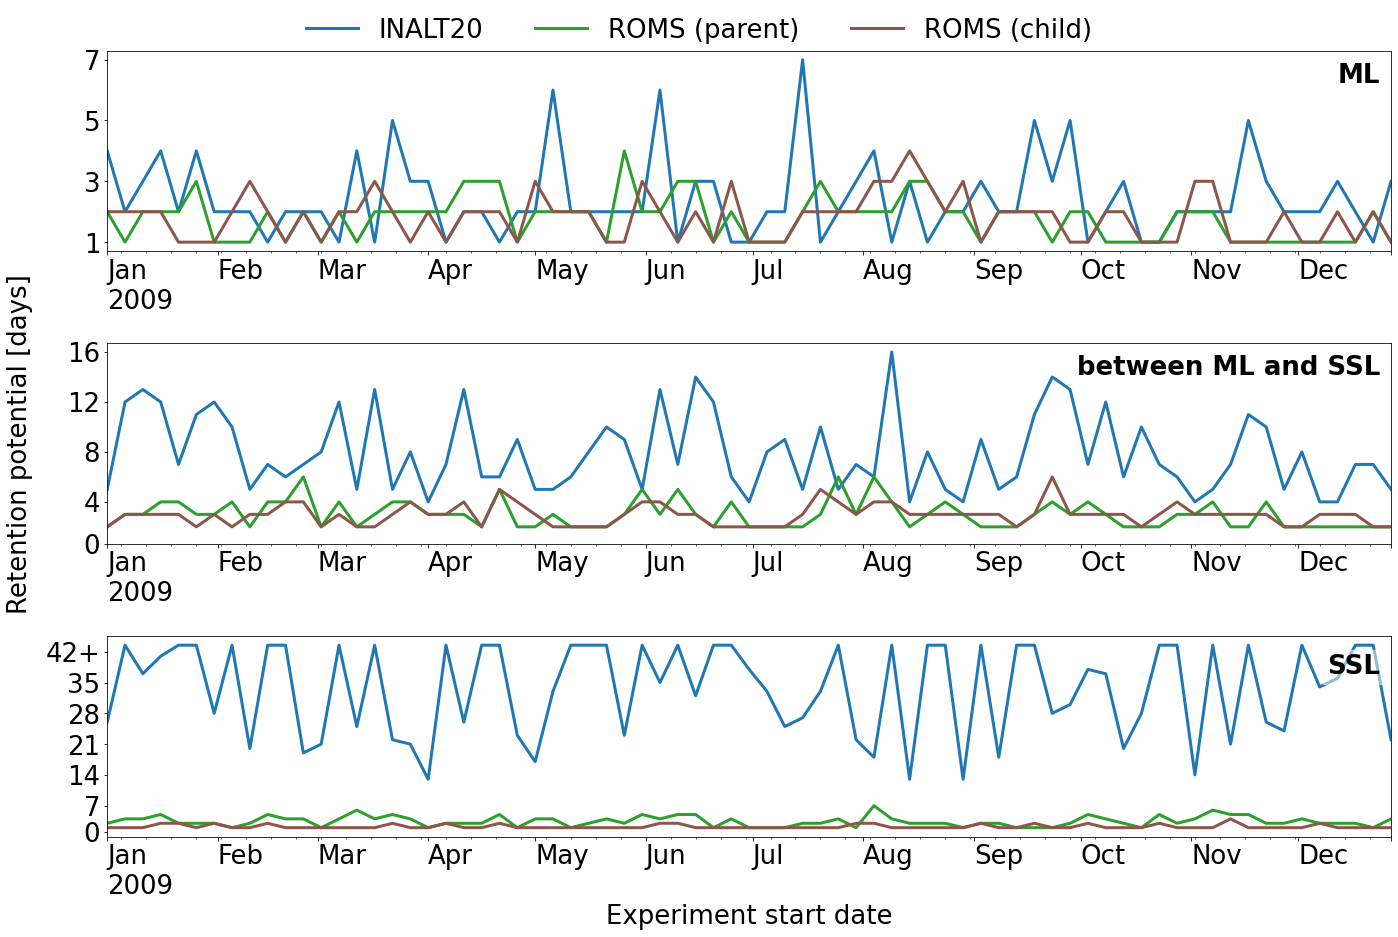

In [16]:
plt.rcParams.update({'font.size': 26})

fig, axs = plt.subplots(3, 1, figsize=(20, 13))

dates = pd.date_range('2009-01-01', periods=12, freq='M')

ylabels = ['','Retention potential [days]\n ','']

INALT = ['INALT-ML', 'INALT-ML-to-tip', 'INALT-tip-to-1500']
ROMS = ['ROMS-ML', 'ROMS-ML-to-tip', 'ROMS-tip-to-1500']
ROMSchild = ['ROMSchild-ML', 'ROMSchild-ML-to-tip', 'ROMSchild-tip-to-1500']

for i, ax in enumerate(axs, start=1):
    line1=retentions[INALT[i - 1]].plot(color='tab:blue', label='INALT20', linewidth=3, ax=ax)
    line2=retentions[ROMS[i - 1]].plot(color='tab:green', label='ROMS (parent)', linewidth=3, ax=ax)
    line3=retentions[ROMSchild[i - 1]].plot(color='tab:brown', label='ROMS (child)', linewidth=3, ax=ax)
    
    ax.text('2009-12-24',[7-.5/6,16-.5/42*16,41.5][i-1],['ML','between ML and SSL','SSL'][i-1],
            horizontalalignment='right',verticalalignment='top', fontweight='bold',
            backgroundcolor=(1, 1, 1, 0.5))
    
    formatted_dates = [date.strftime('%b\n%Y' if i == 0 else '%b') for i, date in enumerate(dates)]
    ax.set_xticklabels(formatted_dates, ha='left')
    ax.set_xlabel(['','','Experiment start date'][i-1])
    ax.set_ylabel(ylabels[i-1])
    
    ax.set_yticks([[1,3,5,7],[5/8,4, 8, 12, 16],[1, 7, 14, 21, 28, 35, 42]][i-1])
    if i == 2:
        ax.set_yticklabels([0,4, 8, 12, 16])
    if i == 3:
        ax.set_yticklabels(['0', '7', '14', '21', '28', '35', '42+'])
        
    if 'INALT20' not in labels:
        lines.append(line1)
        labels.append('INALT20')
    if 'ROMS (parent)' not in labels:
        lines.append(line2)
        labels.append('ROMS (parent)')
    if 'ROMS (child)' not in labels:
        lines.append(line3)
        labels.append('ROMS (child)')

fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=3, frameon=False)

plt.tight_layout()
plt.savefig('../../output_data/rp-year.pdf', bbox_inches='tight')
plt.show()


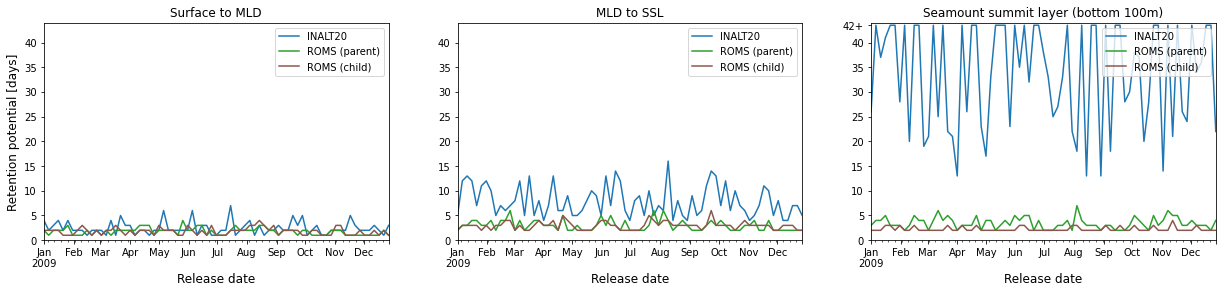

In [11]:
plt.figure(figsize=(21,4))
plt.subplot(1, 3,1)
retentions['INALT-ML'].plot(color='tab:blue',label='INALT20')
retentions['ROMS-ML'].plot(color='tab:green',label='ROMS (parent)')
retentions['ROMSchild-ML'].plot(color='tab:brown',label='ROMS (child)')
plt.title('Surface to MLD', fontsize=12)
plt.xlabel('Release date', fontsize =12)
plt.ylabel('Retention potential [days]', fontsize =12)
plt.ylim([0,44])
#plt.gca().invert_xaxis()
plt.legend()

plt.subplot(1, 3,2)
retentions['INALT-ML-to-tip'].plot(color='tab:blue',label='INALT20')
retentions['ROMS-ML-to-tip'].plot(color='tab:green',label='ROMS (parent)')
retentions['ROMSchild-ML-to-tip'].plot(color='tab:brown',label='ROMS (child)')
plt.title('MLD to SSL', fontsize=12)
plt.xlabel('Release date', fontsize =12)
#plt.ylabel('Retention potential [days]', fontsize =12)
plt.ylim([0,44])
#plt.gca().invert_xaxis()
plt.legend()

plt.subplot(1, 3,3)
retentions['INALT-tip-to-1500'].plot(color='tab:blue',label='INALT20')
#plt.scatter(dates,retentions['INALT-tip-to-1500'],color='tab:blue',s=4)
retentions['ROMS-tip-to-1500'].plot(color='tab:green',label='ROMS (parent)')
retentions['ROMSchild-tip-to-1500'].plot(color='tab:brown',label='ROMS (child)')
plt.title('Seamount summit layer (bottom 100m)', fontsize=12)
plt.xlabel('Release date', fontsize =12)
#plt.ylabel('Retention potential [days]', fontsize =12)
plt.ylim([0,44])
plt.yticks([0,5,10,15,20,25,30,35,40,43.5],[0,5,10,15,20,25,30,35,40,'42+'])
#plt.gca().invert_xaxis()
plt.legend(loc=1);